<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/negative-microexpresions/Microexpression_recognition_tesis_maestria_MicroExpSTCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Microexpresion recognition**
**MicroExpSTCNN Model**

Natalia Zartha
Maestria en Ingenira de Sistemas y Computación, 2021

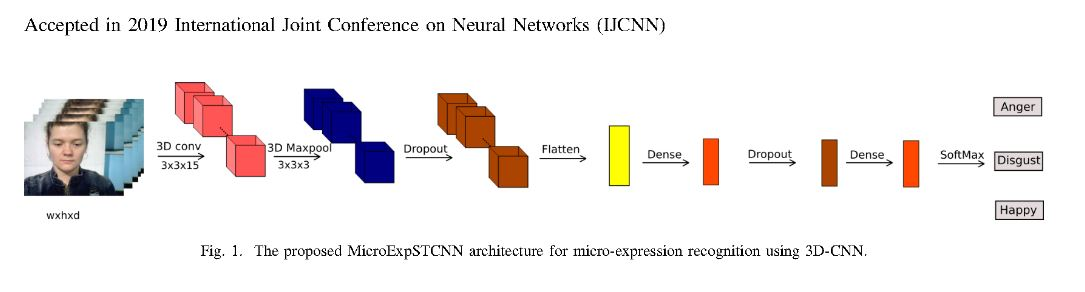

In [55]:
import os
import cv2
import numpy
import imageio
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
from keras import backend as K
import sys

#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

#Import files from google drive

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#SMIC

In [49]:

image_rows, image_columns, image_depth = 64, 64, 18

training_list = []

CODE_PATH = 'drive/MyDrive/MAESTRIA ING DE SISTEMAS/1. MICROEXPRESIONES FACIALES TRABAJO DE GRADO/3. Codigo/microexpresion-recognition-colab'
SMIC_path = CODE_PATH + '/datasets/SMIC'
CASMEII_path = CODE_PATH + '/datasets/CASMEII'



negativepath =SMIC_path +'/SMIC_all_cropped/HS/s1/micro/negative/'
positivepath =SMIC_path +'/SMIC_all_cropped/HS/s1/micro/positive/'
surprisepath =SMIC_path +'/SMIC_all_cropped/HS/s1/micro/surprise/'


print("-------------------------negativepath----------------------")  

directorylisting = os.listdir(negativepath)
for video in directorylisting:
    videopath = negativepath + video
    frames = []
    framelisting = os.listdir(videopath)
    framerange = [x for x in range(18)]



    for frame in framerange:
           imagepath = videopath + "/" + framelisting[frame]
           image = cv2.imread(imagepath)
           imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
           grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
           frames.append(grayimage)
    frames = numpy.asarray(frames)
    videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
    
    training_list.append(videoarray)




print("-------------------------positivepath----------------------")  

directorylisting = os.listdir(positivepath)
for video in directorylisting:
    videopath = positivepath + video
    frames = []
    framelisting = os.listdir(videopath)
    framerange = [x for x in range(18)]
    for frame in framerange:
           imagepath = videopath + "/" + framelisting[frame]
           image = cv2.imread(imagepath)
           imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
           grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
           frames.append(grayimage)
    frames = numpy.asarray(frames)
    videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
    training_list.append(videoarray)




print("-------------------------surprisepath----------------------")  

directorylisting = os.listdir(surprisepath)
for video in directorylisting:
    videopath = surprisepath + video
    frames = []
    framelisting = os.listdir(videopath)
    framerange = [x for x in range(18)]
    for frame in framerange:
           imagepath = videopath + "/" + framelisting[frame]
           image = cv2.imread(imagepath)
           imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
           grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
           frames.append(grayimage)
    frames = numpy.asarray(frames)
    videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
    training_list.append(videoarray)

training_list = numpy.asarray(training_list)
trainingsamples = len(training_list)

print("len trainingsamples")
print(trainingsamples)



traininglabels = numpy.zeros((trainingsamples, ), dtype = int)

traininglabels[0:66] = 0
traininglabels[66:113] = 1
traininglabels[113:156] = 2

traininglabels = np_utils.to_categorical(traininglabels, 3)

training_data = [training_list, traininglabels]
(trainingframes, traininglabels) = (training_data[0], training_data[1])


training_set = numpy.zeros((trainingsamples, 1, image_rows, image_columns, image_depth))


print("range(trainingsamples)")
print(range(trainingsamples))


for h in range(trainingsamples):
    training_set[h][0][:][:][:] = trainingframes[h, :, :, :]


training_set = training_set.astype('float32')
training_set -= numpy.mean(training_set)
training_set /= numpy.max(training_set)

print("training_set.shape")
print(training_set.shape)


# Save training images and labels in a numpy array
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy', training_set)
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy', traininglabels)

# Load training images and labels that are stored in numpy array
"""
training_set = numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy')
traininglabels =numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy')
"""

# MicroExpSTCNN Model
model = Sequential()
model.add(Convolution3D(32, (3, 3, 15), input_shape=(1, image_rows, image_columns, image_depth), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(128, init='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(3, init='normal'))
model.add(Dense(3, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

model.summary()

filepath=CODE_PATH+"/weights_microexpstcnn/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#########filepath=CODE_PATH+"/weights_microexpstcnn/model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Load pre-trained weights
#model.load_weights(CODE_PATH+'/weights_microexpstcnn/weights-improvement-40-0.69.hdf5')
model.load_weights(CODE_PATH+'/weights_microexpstcnn/weights-improvement-01-1.00.hdf5')

# Spliting the dataset into training and validation sets
train_images, validation_images, train_labels, validation_labels =  train_test_split(training_set, traininglabels, test_size=0.2, random_state=4)

# Save validation set in a numpy array
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy', validation_images)
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy', validation_labels)

# Load validation set from numpy array
validation_images = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy')
validation_labels = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy')


# Training the model
#hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, nb_epoch = 100, shuffle=True)
hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, epochs = 100, shuffle=True)




-------------------------negativepath----------------------
-------------------------positivepath----------------------
-------------------------surprisepath----------------------
len trainingsamples
6
range(trainingsamples)
range(0, 6)
training_set.shape
(6, 1, 64, 64, 18)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 32, 62, 62, 4)     4352      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 32, 20, 20, 1)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 20, 20, 1)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)   

#Predictions


In [56]:

# Finding Confusion Matrix using pretrained weights

print("------------------validation_images--------------------")
print(validation_images.shape)
print(validation_images)
print("------------------validation_labels--------------------")
print(validation_labels.shape)
print(validation_labels)



predictions = model.predict(validation_images)
predictions_labels = numpy.argmax(predictions, axis=1)


print("-------------------predictions------------------------")
print(predictions)
print("-------------------predictions_labels-----------------")
print(predictions_labels.shape)
print(predictions_labels)

validation_labels_y = numpy.argmax(validation_labels, axis=1)



print("-------------------validation_labels_new---------------")
print(validation_labels_y.shape)
print(validation_labels_y)

cfm = confusion_matrix(validation_labels_y, predictions_labels)
print("------------------------------confusion_matrix------------------------------")
print (cfm)

print('Accuracy score :', accuracy_score(validation_labels_y,predictions_labels) )


print('Classification report :', classification_report(validation_labels_y,predictions_labels) )

------------------validation_images--------------------
(2, 1, 64, 64, 18)
[[[[[-0.349219   -0.35770464 -0.349219   ... -0.35770464 -0.34073332
     -0.349219  ]
    [-0.29830506 -0.29830506 -0.28981942 ... -0.28981942 -0.2728481
     -0.28133374]
    [-0.23890549 -0.24739113 -0.25587678 ... -0.25587678 -0.23890549
     -0.24739113]
    ...
    [-0.22193418 -0.23890549 -0.23041983 ... -0.25587678 -0.23890549
     -0.23890549]
    [-0.23041983 -0.24739113 -0.22193418 ... -0.25587678 -0.23041983
     -0.24739113]
    [-0.25587678 -0.2728481  -0.25587678 ... -0.2728481  -0.26436245
     -0.26436245]]

   [[-0.26436245 -0.28133374 -0.25587678 ... -0.2728481  -0.26436245
     -0.26436245]
    [-0.23041983 -0.23890549 -0.23890549 ... -0.23890549 -0.23890549
     -0.23890549]
    [-0.20496286 -0.21344852 -0.20496286 ... -0.18799156 -0.18799156
     -0.17950591]
    ...
    [-0.21344852 -0.23890549 -0.23041983 ... -0.24739113 -0.23890549
     -0.23041983]
    [-0.22193418 -0.23890549 -0.230419

In [51]:
train_images.shape


(4, 1, 64, 64, 18)

In [52]:
validation_images.shape

(2, 1, 64, 64, 18)

In [53]:

#y_predit = model.predict(train_images[:,:,:,:,14])








#revisar x el que el train_images.shape esta dando con el  4, 1


#revisar el modelo 

#por que los traingns deben ser asi
#traings
#1, 64, 64, 3

#todas las imagenes 
#18, 1, 64, 64, 3

#y revisar por que solo se tienen 18 imagenes

#Save model as json string

In [54]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)